In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import torch
import torch.nn as nn
from torchvision.models import resnet50, ResNet50_Weights
import torchvision.transforms as transforms
import ssl
ssl._create_default_https_context = ssl._create_unverified_context


# Question 1

In [2]:
resnet = resnet50(weights=ResNet50_Weights.DEFAULT)
resnet.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [3]:
def Preprocess_Img(img):
    img = transforms.ToTensor()(img)
    # img = transforms.Resize((224, 224))(img)
    img = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])(img)
    img = img.unsqueeze(0)
    img = img.requires_grad_()
    return img

In [4]:
def Get_Prediction(img):
    pred = resnet(img)
    return pred

In [5]:
def get_grad(img):
    grad = img.grad
    grad = grad.squeeze(0)
    grad = grad.permute(1, 2, 0)
    grad = grad.detach().numpy()
    grad = np.abs(grad)
    grad = grad / np.max(grad)
    return grad

# Vanilla Backprop

(183, 276, 3)


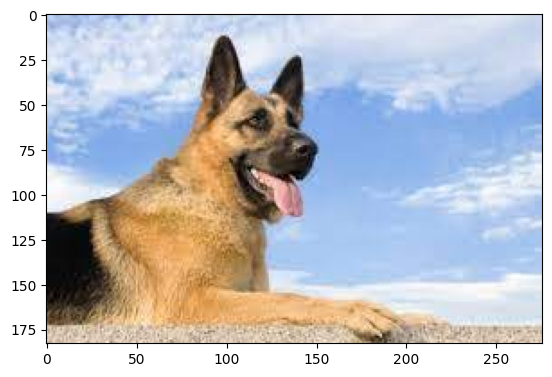

tensor([235])


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torchvision/transforms/functional.py:152: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_numpy.cpp:212.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


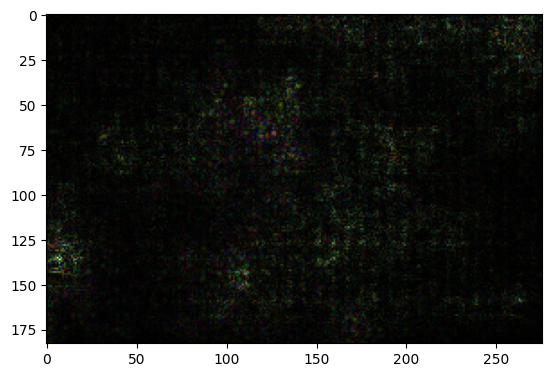

In [6]:
img = plt.imread('i1.jpg')
print(img.shape)
# Preprocessing Image
plt.imshow(img)
plt.show()
img = Preprocess_Img(img)
# Forward pass
out = Get_Prediction(img)
# Get the index of the maximum value
pred = torch.argmax(out, dim=1)
print(pred)

# Backward pass and visualize the gradients
loss = out[0, pred]
loss.backward()

grad = get_grad(img)
plt.imshow(grad)

# Guided BackPropogation

In [7]:
def prep_input(path):
    image =Image.open(path)

    preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),])

    image = preprocess(image)
    image.unsqueeze_(0)

    return image


def prep_output(img_tensor):
    invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                    std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                            transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                    std = [ 1., 1., 1. ]),
                            ])
    out = invTrans(img_tensor)[0]
    out = out.detach().numpy().transpose(1, 2, 0)


    return out


def plot_maps(img1, img2,vmin=0.3,vmax=0.7, mix_val=2):
    f = plt.figure(figsize=(15,45))
    plt.subplot(1,2,1)
    plt.imshow(img1,vmin=vmin, vmax=vmax, cmap="gray")
    plt.axis("off")
    plt.subplot(1,2,2)
    plt.imshow(img2, cmap = "gray")
    plt.axis("off")

def norm_flat_image(img):
    grads_norm = prep_output(img)
    grads_norm = grads_norm[:,:,0]+ grads_norm[:,:,1]+ grads_norm[:,:,2]

    grads_norm = (grads_norm - np.min(grads_norm))/ (np.max(grads_norm)- np.min(grads_norm))
    return grads_norm

In [8]:
def relu_hook_function(module, grad_in, grad_out):
    if isinstance(module, torch.nn.ReLU):
        return (torch.clamp(grad_in[0], min=0.),)

In [9]:
for i, module in enumerate(resnet.modules()):
    if isinstance(module, torch.nn.ReLU):
        print(resnet.named_modules())
        module.register_backward_hook(relu_hook_function)

<generator object Module.named_modules at 0x13a7fc430>
<generator object Module.named_modules at 0x13a7fc580>
<generator object Module.named_modules at 0x13a7fc580>
<generator object Module.named_modules at 0x13a7fc580>
<generator object Module.named_modules at 0x13a7fc580>
<generator object Module.named_modules at 0x13a7fc580>
<generator object Module.named_modules at 0x13a7fc580>
<generator object Module.named_modules at 0x13a7fc580>
<generator object Module.named_modules at 0x13a7fc580>
<generator object Module.named_modules at 0x13a7fc580>
<generator object Module.named_modules at 0x13a7fc580>
<generator object Module.named_modules at 0x13a7fc580>
<generator object Module.named_modules at 0x13a7fc580>
<generator object Module.named_modules at 0x13a7fc580>
<generator object Module.named_modules at 0x13a7fc580>
<generator object Module.named_modules at 0x13a7fc580>
<generator object Module.named_modules at 0x13a7fc580>


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


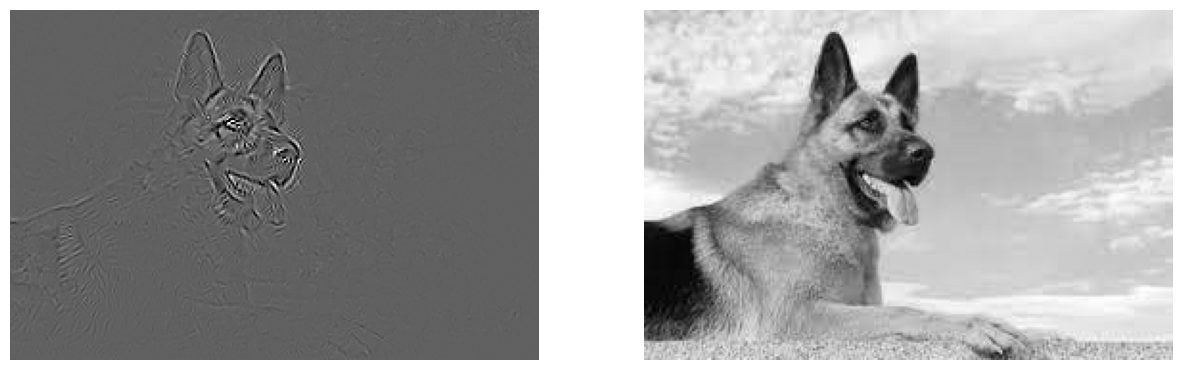

In [10]:
img.requires_grad = True

# Forward pass
out = Get_Prediction(img)
# BackProp
loss = out[0, pred]
loss.backward()
grads = img.grad

plot_maps(norm_flat_image(grads),norm_flat_image(img) )



# Question 2

$f(x) = 10x^2 + y^2$ 

In [11]:
def func(x, y):
    return 10 * x**2 + y**2

In [12]:
def grad_func(x, y):
    return np.array([20 * x, 2 * y])

In [13]:
def VanillaSGD(W, lr):
    W = W - lr * grad_func(W[0], W[1])
    return W

In [14]:
def MomentumSGD(W, V, lr, beta):
    V = beta * V + lr * grad_func(W[0], W[1])
    W = W - V
    return W, V

In [15]:
def NestrovMomentum(W, V, lr, beta):
    V = beta * V + lr * grad_func(W[0] - beta * V[0], W[1] - beta * V[1])
    W = W - V
    return W, V

In [16]:
def AdaGrad(W, G, lr, eps):
    G = G + grad_func(W[0], W[1])**2
    W = W - lr * grad_func(W[0], W[1]) /(eps + np.sqrt(G))
    return W, G

In [17]:
def RMSProp(W, G, lr, beta, eps):
    G = beta * G + (1 - beta) * grad_func(W[0], W[1])**2
    W = W - lr * grad_func(W[0], W[1]) /(eps + np.sqrt(G))
    return W, G

In [18]:
# Initializing W
W = np.random.randint(40, size=(2))
W = W - np.array([20, 20])
print(W)

[-14 -10]


In [19]:
W1 = W2 = W3 = W4 = W5 = W
# Hyperparameters
lr1 = 0.045
lr2 = 0.045
lr3 = 0.045
lr4 = 4.5
lr5 = 1
beta1 = 0.6
beta2 = 0.6
beta3 = 0.9
eps1 = 1e-8
eps2 = 1e-8

V1 = np.zeros(2)
V2 = np.zeros(2)
G1 = np.zeros(2)
G2 = np.zeros(2)

list1 = np.zeros((2, 50))
list2 = np.zeros((2, 50))
list3 = np.zeros((2, 50))
list4 = np.zeros((2, 50))
list5 = np.zeros((2, 50))

for i in range(50):
    W1 = VanillaSGD(W1, lr1)
    list1[:,i] = W1
    W2, V1 = MomentumSGD(W2, V1, lr2, beta1)
    list2[:,i] = W2
    W3, V2 = NestrovMomentum(W3, V2, lr3, beta2)
    list3[:,i] = W3
    W4, G1 = AdaGrad(W4, G1, lr4, eps1)
    list4[:,i] = W4
    W5, G2 = RMSProp(W5, G2, lr5, beta3, eps2)
    list5[:,i] = W5

print("Vanilla SGD: ", W1)
print("Momentum SGD: ", W2)
print("Nestrov Momentum: ", W3)
print("AdaGrad: ", W4)
print("RMSProp: ", W5)

Vanilla SGD:  [-1.40000000e-49 -8.95508301e-02]
Momentum SGD:  [-1.90670466e-05  1.67653176e-05]
Nestrov Momentum:  [-2.11350454e-30 -9.88187877e-07]
AdaGrad:  [-3.30388870e-05 -7.97338519e-10]
RMSProp:  [ 2.19456849e-18 -2.89522382e-17]


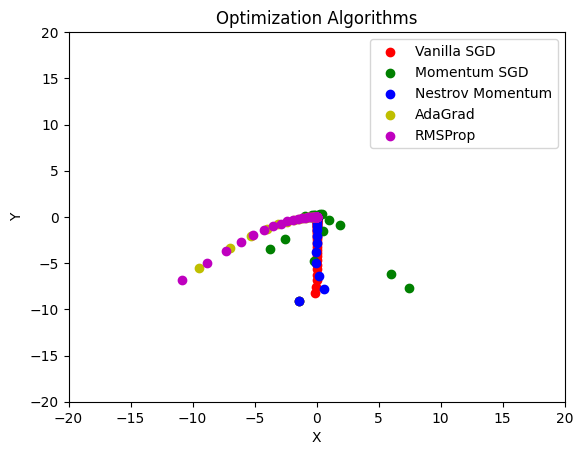

In [20]:
# Creating the animation

fig, ax = plt.subplots()


def init():
    ax.set_xlim(-20, 20)
    ax.set_ylim(-20, 20)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Optimization Algorithms')

def update(i):
    ax.clear()
    ax.scatter(list1[0,:i], list1[1,:i], c='r', label='Vanilla SGD')
    ax.scatter(list2[0,:i], list2[1,:i], c='g', label='Momentum SGD')
    ax.scatter(list3[0,:i], list3[1,:i], c='b', label='Nestrov Momentum')
    ax.scatter(list4[0,:i], list4[1,:i], c='y', label='AdaGrad')
    ax.scatter(list5[0,:i], list5[1,:i], c='m', label='RMSProp')
    ax.legend(loc='upper right')
    ax.set_xlim(-20, 20)
    ax.set_ylim(-20, 20)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Optimization Algorithms')

ani = animation.FuncAnimation(fig, update, frames=50, init_func=init, interval=100, blit=False)
# plt.show()

writer = animation.PillowWriter(fps=10)
ani.save("optimisationalgorithms.gif", writer=writer)